# MULTICLASS - CLASSIFICATION NEURAL NETWORK FROM SCRATCH WITH MORE NEURONS

### Disclaimer: Much of this is same as the previous one! But with MORE NEURONS IN HIDDEN LAYER and FEATURE SCALING. That helps us to increase the accuracy!
### Hell yeah!

### Dataset : FASHION - MNIST
### Info : Fashion-MNIST is a dataset consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. 

## Loading Dataset from Kaggle


First let us download the dataset from Kaggle.

In [0]:
!mkdir ~/.kaggle
!cp /content/gdrive/My\ Drive/Colab\ Notebooks/Kaggle/kaggle.json ~/.kaggle/kaggle.json

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [20]:
!kaggle datasets download -d zalando-research/fashionmnist -p /content/

 95% 65.0M/68.8M [00:01<00:00, 40.3MB/s]
100% 68.8M/68.8M [00:01<00:00, 49.1MB/s]


In [21]:
!unzip /content/fashionmnist.zip

Archive:  /content/fashionmnist.zip
  inflating: t10k-images-idx3-ubyte  
  inflating: fashion-mnist_test.csv  
  inflating: train-labels-idx1-ubyte  
  inflating: train-images-idx3-ubyte  
  inflating: fashion-mnist_train.csv  
  inflating: t10k-labels-idx1-ubyte  


Great! Let's Begin.

## Dataset visualisation

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
import os
from zipfile import ZipFile
from sklearn.preprocessing import normalize

In [22]:
data = pd.read_csv('fashion-mnist_train.csv')
print(data.shape)
data.head()

(60000, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


In [23]:
X_train = data.iloc[:,1:].values
Y_train = data.iloc[:,0:1].values
print(X_train.shape)
print(Y_train.shape)

(60000, 784)
(60000, 1)


So the training dataset consists of 28*28 pixels images. Each image corresponds to one fashion accessory. There are 61418 such images.

The label column classifies the image. The labels are as follows:

-  0 T-shirt/top 
- 1 Trouser 
- 2 Pullover 
- 3 Dress 
- 4 Coat 
- 5 Sandal 
- 6 Shirt 
- 7 Sneaker 
- 8 Bag 
- 9 Ankle boot

Let's see 100 random examples.

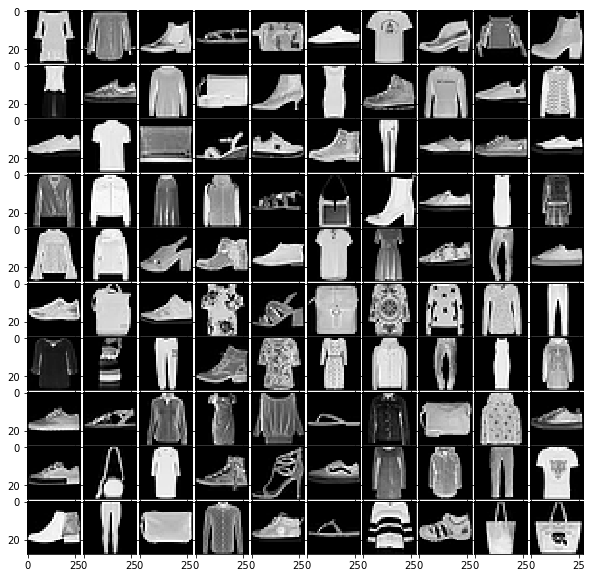

In [24]:
def Visualise(X,number):
  rand_indices = np.random.randint(0,high=X.shape[0],size=number)
  img1 = X[rand_indices,:]
  n = int(np.sqrt(number))
  fig, ax = plt.subplots(nrows=n,
                         ncols=n,
                         sharey = True, sharex = True)
  fig.set_figwidth(10)
  fig.set_figheight(10)
  fig.subplots_adjust(wspace=0.025, hspace=0.025)
  for i in range(number):
    img = img1[i].reshape(28,28)
    ax[int(i/n),i%n].imshow(img, cmap='gray')

Visualise(X_train,100)

###Feature Scaling

In [0]:
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


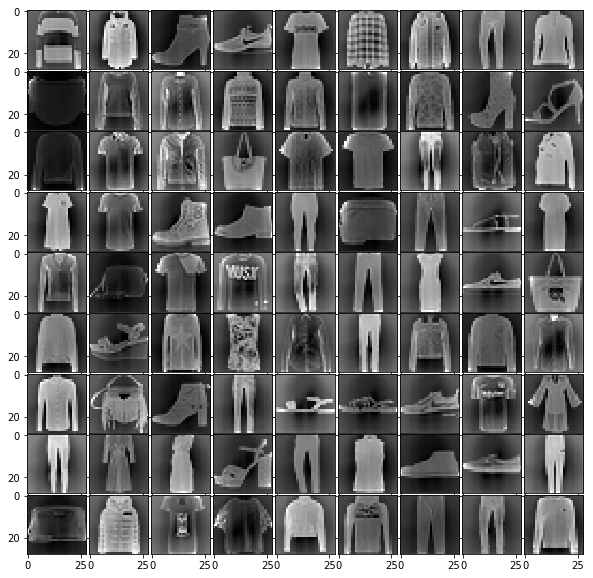

In [26]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
Visualise(X_train, 81)

## Deciding Neural Network Architecture


Now let us begin decide our neural network architecture.

Basically it would be a 3 layer neural network, with 28*28 = 784 input neurons. 1 neuron for each pixel in the image. 

Now we have to decide the no. of hidden layers and no. of neurons in each hidden Layer.
Well it's always good to go with a single hidden layer. And going with the accepted answer on this question on stack overflow question[https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw],
the ***number of neurons in the hidden layer should be 350***.

### This time we will keep the number of neurons in the hidden layer 350, and to make sure that our neural network doesn't fit the triaing set, we would keep the regularisation parameter high.

In [0]:
input_layer_size = 784
hidden_layer_size = 350
output_layer_size = 10

m = X_train.shape[0]  #no. of training examples

## Applying PCA to reduce dimensions will not work here
Since our each training example is $28 * 28$ pixels , which corresponds to 784 features, training our neural network becomes a tedious task. So, for reducing the dimensions we may at first think to apply ***Principal Component Analysis*** to the data to reduce the dimensions.


But we should understand the fact that here we are dealing with Multi classification here, hence each of the ***different classes would have their own different Principal Components***. Hence we can't apply PCA here.

For more information about PCA you can refer to this [Programming Exercise](https://github.com/Sachinkumar04428/Machine-Learning-by-Andrew-Ng-Implementation-in-Python/blob/master/Programming%20Assignments/Exercise%207/exercise7.ipynb) and to this [Exercise](https://halwa.com).

## Deciding activation function :
## Sigmoid function

We will use sigmoid function as our activation function.
It looks something like this. ![alt text]()

In [0]:
def sigmoid(z):
  #returns the sigmoid of a matrix,vector or scalar
  return 1/(1 + np.exp(-z))

## Coding the Backpropagation algorithm

Now Let us write our code for backpropagation. 
This function first performs the forward propagation to compute ouput values for the passed in matrices $\Theta^{1}$ and $\Theta^{2}$. And then it performs back propagation to compute the vectors $\delta^{1}$ and $\delta^{2}$. 

Using $\delta^{1}$ and $\delta^{2}$, it compute $\Delta^{1}$ and $\Delta^{2}$.
and which are then finally used to compute $D^{1}$ and $D^{2}$ respectively.

In [0]:
#we will require this in the backpropagation algorithm
def sigmoidGradient(z):
  
  return sigmoid(z)*(1 - sigmoid(z))

In [0]:
#We will create an algorithm independent of this particular application
def backPropagation(X, Y, Theta1, Theta2, lambda_=0.0):
  
  m = X.shape[0]
  
  J = 0                                          #J is our cost function
  
  Theta1_grad = np.zeros(Theta1.shape)
  Theta2_grad = np.zeros(Theta2.shape)
  
  for i in range(m):
    a_1 = np.hstack((np.ones((1)),X[i]))         # added bias to input layer
    z_2 = np.dot(Theta1,a_1)
    a_2 = np.hstack((np.ones(1), sigmoid(z_2)))  # added bias to hidden layer
    z_3 = np.dot(Theta2, a_2)
    a_3 = sigmoid(z_3)
    
    '''Since our data set has only Y labeled from 0-9, but to perform multiclass
       Classification using neural networks, we need it to be in form of vector
       of size = ouput layer size'''
    
    y = np.zeros(output_layer_size)
    
    y[int(Y[i])]= 1
    
    delta_3 = a_3 - y
    delta_2 = np.dot(Theta2[:,1:].T, delta_3)*sigmoidGradient(z_2)
    
    Theta1_grad = Theta1_grad + np.dot(delta_2.reshape(delta_2.shape[0],1), 
                                       a_1.reshape(a_1.shape[0],1).T)
    Theta2_grad = Theta2_grad + np.dot(delta_3.reshape(delta_3.shape[0],1),
                                       a_2.reshape(a_2.shape[0],1).T)
    
    #calculating cost function
    J += np.sum(-y*np.log(a_3) - (1 - y)*np.log(1 - a_3))
    
  
  #calculating regularised cost function 
  #note that we are not including the 1st column 
  J = J/m + (lambda_/(2*m))*(np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))

  D_1 = np.hstack( ((1/m)*Theta1_grad[:,0:1], 
                   (1/m)*(Theta1_grad[:,1:] + lambda_*Theta1[:,1:])))
                  
  D_2 = np.hstack(((1/m)*Theta2_grad[:,0:1], 
                   (1/m)*(Theta2_grad[:,1:] + lambda_*Theta2[:,1:])))
  
  return J,D_1,D_2
                  

## Gradient Descent

Now let us define our Gradient Descen function. 

Basically Gradient Descent has the function of minimizing the cost function by changing the matrices Theta, which are responsible for predicting the ouptut. 

Basically Gradient Descent performs the following function :


***repeat until convergence ***: {

$\Theta^{(l)}_{i,j} =  \Theta^{(l)}_{i,j}  - \alpha \frac{\partial }{\partial \Theta^{(l)}_{i,j}}J(\Theta)$
   
} ***simultaneous update for all {$i$ , $j$, $l$ }***


And the second term $ \frac{\partial }{\partial \Theta^{(l)}_{i,j}}J(\Theta)$ , is given by our beautiful ***Backpropagation algorithm***.

One thing that I learned from performing this simulation completely 4 times, each time taking roughly of 13 hours is that you must save your ***intermediate results and download them***.

***Especially if you are using google collab, which disconnects any instance(like after 4-5  hours) with no reason(happened to me :) ).***

So let's define a function which will help us save our files.

In [0]:
def save_file(cost_func, Theta1, Theta2, itr):
  
    df_Theta1 = pd.DataFrame(Theta1)
    df_Theta2 = pd.DataFrame(Theta2)
    df_Cost_func = pd.DataFrame(cost_func)
    
    file_name = f'iteration {itr}'
    directory = "/content/drive/My Drive/Colab Notebooks/fashion mnist Neural net data"
    
    os.chdir(directory)
    os.mkdir('{}'.format(file_name))
    
    df_Theta1.to_csv('{}/Theta1_{}.csv'.format(file_name, itr))
    df_Theta2.to_csv('{}/Theta2_{}.csv'.format(file_name, itr))
    df_Cost_func.to_csv('{}/Cost_Func_{}.csv'.format(file_name, itr))
    
    os.chdir('/content')
    
    print('All files saved successfully')       

In [0]:
def Gradient_Descent(X, Y, learning_rate, iterations, 
                      input_layer_size, 
                      hidden_layer_size, 
                      output_layer_size, 
                      initial_iteration,
                      lambda_):
    
    print('shape of training dataset',X.shape)
    print('input layer size =',input_layer_size)
    print('hidden layer size =',hidden_layer_size)
    print('output layer size =',output_layer_size)
    
    directory = "/content/drive/My Drive/Colab Notebooks/fashion mnist Neural net data/iteration {}".format(initial_iteration)
    
    if initial_iteration==0:
      Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
      Theta2 = randInitializeWeights(hidden_layer_size, output_layer_size)
      cost_func = []
    else:
      theta1_df = pd.read_csv(f'{directory}/Theta1_{initial_iteration}.csv')
      theta2_df = pd.read_csv(f'{directory}/Theta2_{initial_iteration}.csv')
      cf_df = pd.read_csv(f'{directory}/Cost_Func_{initial_iteration}.csv')
      print('Continued from iteration',initial_iteration)
    
      Theta1 = theta1_df.values[:,1:]  #avoiding that first irrelevant coloumn
      Theta2 = theta2_df.values[:,1:]
      cost_func = cf_df.values[:,1:].reshape(cf_df.shape[0]).tolist()  #ndarray to list
    
    interupt = initial_iteration + 50  
    curr_irr = 0
    
    for i in range(initial_iteration,iterations):
      
      c_f, Theta1_grad, Theta2_grad = backPropagation(X, Y, Theta1, Theta2, lambda_)
      cost_func.append(c_f)
      
      if i>=1 and cost_func[i]>cost_func[i-1]:
        print('Cost function increasing')
        break
      
      Theta1 = Theta1 - learning_rate*Theta1_grad
      Theta2 = Theta2 - learning_rate*Theta2_grad
      
      if (i+1)%25==0:
        print('epoch',i+1,'completed. cf =',c_f)
      
      # Showing me the progress
      if (i+1)==interupt:
        plt.plot(np.arange(i+1), cost_func)
        plt.show()
        print('Here is the cost function!')
        interupt += 50
        
        #Saving the files
        save_file(cost_func, Theta1, Theta2, i+1)
        
      curr_irr = i+1
      
    return cost_func, curr_irr, Theta1, Theta2

We must always initialise the weights, i.e. matrices $\Theta_1$ and $\Theta_2$, with random values close to 0. One good method is to keep their domain as [ - $\epsilon$,  $\epsilon$],  where:

##  $\epsilon =  \frac{\sqrt{6}}{ L_{in} + L_{out}}$ 

$L_{in}$ = no. of units in input layer

$L_{out}$ = np. of units in outpu layer.

In [0]:
def randInitializeWeights(L_in, L_out):
  
  #for now I am using 0.5 as that value was coming very small.
  epsilon_init = 0.5
  
  Theta = np.random.rand(L_out, L_in +1)*2*epsilon_init - epsilon_init
  
  return Theta

# Training our model :)

Now let us train our model.

shape of training dataset (60000, 784)
input layer size = 784
hidden layer size = 350
output layer size = 10
Continued from iteration 1750
epoch 1775 completed. cf = 8.658864413480037
epoch 1800 completed. cf = 8.527067889203847


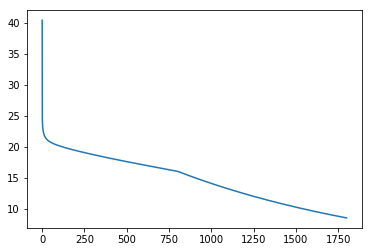

Here is the cost function!
All files saved successfully
epoch 1825 completed. cf = 8.397490619568408
epoch 1850 completed. cf = 8.27009412238679


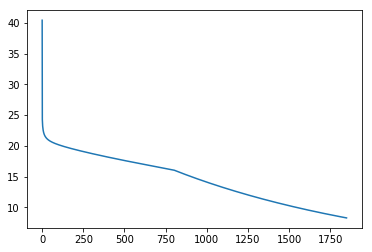

Here is the cost function!
All files saved successfully
epoch 1875 completed. cf = 8.144840666488212
epoch 1900 completed. cf = 8.021693252959697


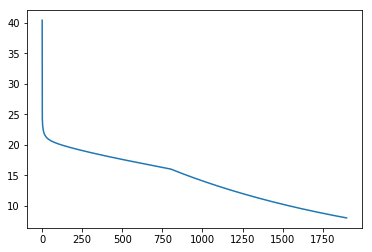

Here is the cost function!
All files saved successfully
epoch 1925 completed. cf = 7.900615592921295
epoch 1950 completed. cf = 7.781572086458799


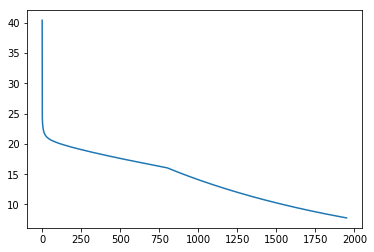

Here is the cost function!
All files saved successfully
epoch 1975 completed. cf = 7.664527803568926
epoch 2000 completed. cf = 7.549448466979356


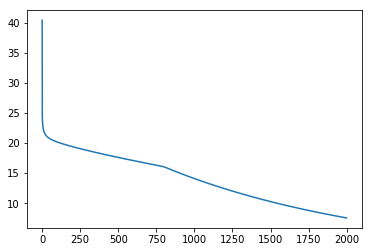

Here is the cost function!
All files saved successfully


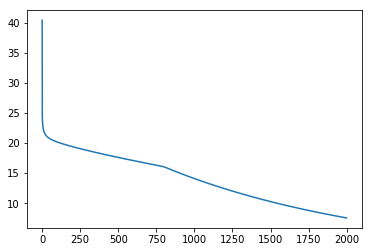

In [39]:
itr = 2000
lambda_ = 100
learning_rate = 0.2
initial_iteration = 1750
cost_func_final, total_itr, Theta1_final, Theta2_final = Gradient_Descent(X_train, Y_train, 
                                                         learning_rate, itr, 
                                                         input_layer_size, 
                                                         hidden_layer_size, 
                                                         output_layer_size, 
                                                         initial_iteration,lambda_)
plt.plot(np.arange(total_itr),cost_func_final)

OK! I am done. No more iterations. 2000 is enough.

## Testing our model    :)

Eventhough it is showing only 1200 epochs above, I did a total of 1400 epochs. So let's test our model now.

In [43]:
test_data = pd.read_csv('fashion-mnist_test.csv')

X_test = test_data.values[:,1:]
Y_test = test_data.values[:,:1]

#Standardising the test data as well
X_test = scaler.transform(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Now let us define predict function which takes in our testing data set X_test, and our calculated weights Theta1 and Theta2. This function returns us the prediction of our model in form of a numpy array, corresponding to every row in our testing dataset X_test.

In [0]:
def predict(Theta1 ,Theta2 ,X_test):
    
    t = X_test.shape[0]
    y_predict = np.ones(t)*-1
    
    for i in range(t):
      a_1 = np.hstack((np.ones((1)),X_test[i]))         # added bias to input layer
      z_2 = np.dot(Theta1,a_1)
      a_2 = np.hstack((np.ones(1), sigmoid(z_2)))  # added bias to hidden layer
      z_3 = np.dot(Theta2, a_2)
      a_3 = sigmoid(z_3)  
    
      y_predict[i] = np.argmax(a_3)
      
    return y_predict

In [0]:
def get_name(y):
  
  names_dict = {
        0: 'T-shirt/top',
        1: 'Trouser',
        2: 'Pullover', 
        3: 'Dress' ,
        4: 'Coat' ,
        5: 'Sandal', 
        6: 'Shirt' ,
        7: 'Sneaker', 
        8: 'Bag' ,
        9: 'Ankle boot'
  }
  return names_dict[y]

For checking .. let us check our model on the first 10 pictures of our data.

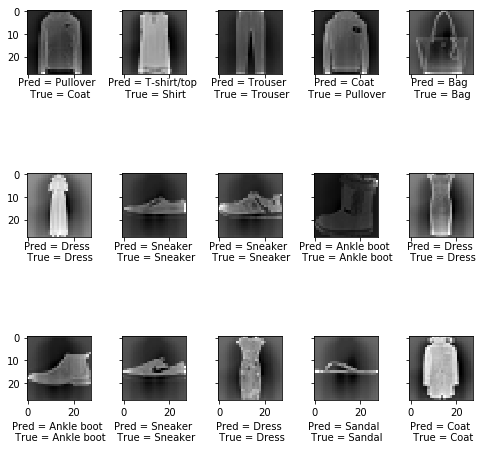

In [47]:
rand_int = np.random.randint(0, X_train.shape[0], size=15)
img1 = X_train[rand_int,:]

fig, ax = plt.subplots(nrows=3,ncols=5,sharey = True, sharex = True)
fig.set_figwidth(8)
fig.set_figheight(8)
fig.subplots_adjust(wspace=0.5,hspace=0.5)

for i in range(15):
    img = img1[i].reshape(28,28)
    row, cal = int(i/5), i%5
    ax[row,cal].imshow(img, cmap='gray')
    
    
    pred_name = get_name(int(predict(Theta1_final, Theta2_final,img1[i].reshape(1,784))))
    true_name = get_name(int(Y_train[rand_int[i]]))
    ax[row,cal].set_xlabel(f'Pred = {pred_name} \n True = {true_name}')


### Nailed it!

That looks great. 

## TESTING ACCURACY

Let us test the accuracy of our neural network using the scikit learn's accuracy_score

In [0]:
from sklearn.metrics import accuracy_score

### Accuracy on Training Data:

In [49]:
Y_Pred_train = predict(Theta1_final, Theta2_final, X_train)
print(accuracy_score(Y_train,Y_Pred_train))

0.8741166666666667


### Accuracy on Testing Data:

In [50]:
Y_Pred_test = predict(Theta1_final, Theta2_final, X_test)
print(accuracy_score(Y_test,Y_Pred_test))

0.8674


So the accuracy is ***86.74 %*** on the Test Dataset. Which is much better than the previous one, which was ***69.38 %***.

Let me plot the graph of the accuracy vs. Number of Iterations.

In [0]:
itr = []
accuracy = []

for i in range(250,2001,50):
  
  file_name = "fashion mnist Neural net data/normalised neural network/iteration {}".format(i)
  directory = "/content/drive/My Drive/Colab Notebooks/{}".format(file_name)
  
  try:
    Theta1 = pd.read_csv(f'{directory}/Theta1_{i}.csv').values[:,1:]
    Theta2 = pd.read_csv(f'{directory}/Theta2_{i}.csv').values[:,1:]
    
    Y_Pred = predict(Theta1, Theta2, X_test)
    accuracy.append(accuracy_score(Y_test,Y_Pred))
    itr.append(i)
  
  except FileNotFoundError:
    pass

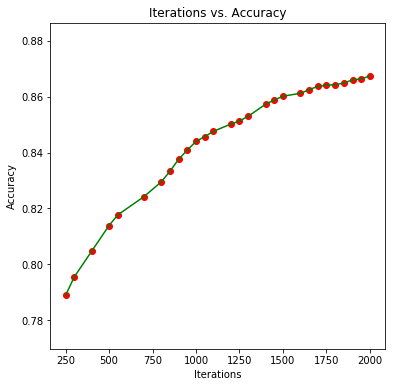

In [76]:
fig, ax = plt.subplots()
ax.scatter(itr, accuracy, color='r')
ax.plot(itr, accuracy, color='g')
ax.set_xlabel('Iterations')
ax.set_ylabel('Accuracy')
ax.set_title('Iterations vs. Accuracy')
fig.set_figwidth(6)
fig.set_figheight(6)

## More Neural Networks are on the way. 